In [1]:
# revise this. Make the current working directory to where the repository is (in your google drive)
%cd drive/MyDrive/fall22_dl_mini_project/

/content/drive/MyDrive/fall22_dl_mini_project


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import os

In [3]:
from models import * 

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
# I modified the ResNet-18 model by making all the number of channels to 1/2

class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Load data

In [7]:
import sklearn

In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [9]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test) # download the train set with test transform as the validation set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
criterion = nn.CrossEntropyLoss()

# training

In [11]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
# Training
def train(epoch, model, trainloader, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(trainloader), total=len(trainloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    return train_loss/(batch_idx+1), 100.*correct/total

In [22]:
def test(epoch, model, testloader, fold = None):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total
    
    return test_loss/(batch_idx+1), acc

In [23]:
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
import numpy as np

def Kfold_training(N_EPOCHS, N_FOLD=5, lr=0.1, isTest=False):

  # make the directory for storing checkpoint
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')

  # Do k-fold cross validation
  splits = KFold(n_splits = N_FOLD, shuffle = True)

  if isTest:
    dataset_len = 1000
  else:
    dataset_len = len(trainset)

  avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc = [0]*N_EPOCHS, [0]*N_EPOCHS, [0]*N_EPOCHS, [0]*N_EPOCHS
  for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(dataset_len))):
    print('Fold {}'.format(fold + 1))
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, sampler=train_sampler)
    validloader = torch.utils.data.DataLoader(validset, batch_size=100, sampler=valid_sampler)

    model = ModifiedResNet(BasicBlock, [2, 2, 2, 2])
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    # optimizer = optim.Adam(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

    for epoch in range(N_EPOCHS):
      start_time = time.time()
      train_loss, train_acc = train(epoch, model, trainloader, optimizer)
      valid_loss, valid_acc = test(epoch, model, validloader, fold+1)
      avg_train_loss[epoch] += train_loss / N_FOLD
      avg_valid_loss[epoch] += valid_loss / N_FOLD
      avg_train_acc[epoch] += train_acc / N_FOLD
      avg_valid_acc[epoch] += valid_acc / N_FOLD
      scheduler.step()
      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      print(f'lr={scheduler.get_last_lr()}')
      print(f'Epoch: {epoch+1} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f"epoch{epoch+1} train loss: {train_loss} train acc: {train_acc} valid acc: {valid_acc}")

  return avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc

In [24]:
rates = [0.1, 0.01, 0.001]
N_EPOCHS = 30
train_hists = []
train_acc_hists = []
valid_hists = []
valid_acc_hists = []

for lr in rates:
  train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist = Kfold_training(N_EPOCHS, N_FOLD=5, lr=lr)
  train_hists.append(train_loss_hist)
  train_acc_hists.append(train_acc_hist)
  valid_hists.append(valid_loss_hist)
  valid_acc_hists.append(valid_acc_hist)

Fold 1


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 29s
epoch1 train loss: 1.786102829268946 train acc: 34.5325 valid acc: 43.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 29s
epoch2 train loss: 1.3292191552277952 train acc: 51.51 valid acc: 57.3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 29s
epoch3 train loss: 1.0594166799094349 train acc: 61.9225 valid acc: 59.55


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 29s
epoch4 train loss: 0.8828996334213037 train acc: 68.795 valid acc: 71.51


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 30s
epoch5 train loss: 0.7523264671666935 train acc: 73.7175 valid acc: 73.85


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 29s
epoch6 train loss: 0.6749260566485956 train acc: 76.3625 valid acc: 67.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 29s
epoch7 train loss: 0.6115300526824622 train acc: 78.755 valid acc: 76.66


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 29s
epoch8 train loss: 0.5791886105133702 train acc: 79.975 valid acc: 74.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 29s
epoch9 train loss: 0.5355602638028301 train acc: 81.6625 valid acc: 78.01


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 29s
epoch10 train loss: 0.5129781916689949 train acc: 82.37 valid acc: 78.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 29s
epoch11 train loss: 0.485080519137672 train acc: 83.4825 valid acc: 76.86


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 29s
epoch12 train loss: 0.4591398805665513 train acc: 84.0725 valid acc: 80.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 29s
epoch13 train loss: 0.43921548880327244 train acc: 84.9225 valid acc: 78.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 30s
epoch14 train loss: 0.40927713523847986 train acc: 85.8725 valid acc: 78.37


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 30s
epoch15 train loss: 0.3970679722178858 train acc: 86.395 valid acc: 77.44


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 29s
epoch16 train loss: 0.36642055789502664 train acc: 87.3525 valid acc: 82.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 29s
epoch17 train loss: 0.3420593618584898 train acc: 88.2475 valid acc: 84.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 29s
epoch18 train loss: 0.31768299325015215 train acc: 89.0075 valid acc: 84.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 29s
epoch19 train loss: 0.2901061378157558 train acc: 89.935 valid acc: 85.99


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 29s
epoch20 train loss: 0.2625687790754885 train acc: 91.0125 valid acc: 87.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 29s
epoch21 train loss: 0.2370029082551551 train acc: 91.895 valid acc: 88.01


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 29s
epoch22 train loss: 0.2138861407534764 train acc: 92.6525 valid acc: 88.33


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 29s
epoch23 train loss: 0.1807633363448393 train acc: 93.745 valid acc: 89.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 30s
epoch24 train loss: 0.15514016354950472 train acc: 94.77 valid acc: 89.31


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 29s
epoch25 train loss: 0.1285059361483533 train acc: 95.5875 valid acc: 90.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 29s
epoch26 train loss: 0.10847400722150415 train acc: 96.355 valid acc: 90.92


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 29s
epoch27 train loss: 0.08981672075157539 train acc: 97.075 valid acc: 91.42


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 29s
epoch28 train loss: 0.07778604814229301 train acc: 97.39 valid acc: 91.37


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 29s
epoch29 train loss: 0.07039728270361599 train acc: 97.7525 valid acc: 91.4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 29s
epoch30 train loss: 0.06765037126386889 train acc: 97.895 valid acc: 91.49
Fold 2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 29s
epoch1 train loss: 1.7692788610824 train acc: 34.7125 valid acc: 44.63


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 29s
epoch2 train loss: 1.3425675537258672 train acc: 51.0975 valid acc: 53.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 30s
epoch3 train loss: 1.0667236283564339 train acc: 61.965 valid acc: 64.63


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 29s
epoch4 train loss: 0.8958761126469499 train acc: 68.09 valid acc: 65.14


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 29s
epoch5 train loss: 0.7583364484409174 train acc: 73.375 valid acc: 70.48


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 29s
epoch6 train loss: 0.6782725751399994 train acc: 76.485 valid acc: 70.22


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 29s
epoch7 train loss: 0.6126633876809677 train acc: 78.7 valid acc: 74.32


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 30s
epoch8 train loss: 0.5729913235472414 train acc: 80.0875 valid acc: 75.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 29s
epoch9 train loss: 0.5384957678973104 train acc: 81.2875 valid acc: 70.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 30s
epoch10 train loss: 0.5142294594083732 train acc: 82.2725 valid acc: 81.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 29s
epoch11 train loss: 0.48665755396833815 train acc: 83.0475 valid acc: 76.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 30s
epoch12 train loss: 0.4630534973578712 train acc: 83.9925 valid acc: 73.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 30s
epoch13 train loss: 0.43778033502185687 train acc: 84.845 valid acc: 80.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 29s
epoch14 train loss: 0.4133627004326342 train acc: 85.6475 valid acc: 79.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 30s
epoch15 train loss: 0.3853775572281676 train acc: 86.7775 valid acc: 82.04


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 29s
epoch16 train loss: 0.36201484610859197 train acc: 87.4625 valid acc: 82.69


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 30s
epoch17 train loss: 0.3418291951901616 train acc: 88.3175 valid acc: 83.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 29s
epoch18 train loss: 0.3199385774497407 train acc: 88.905 valid acc: 86.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 29s
epoch19 train loss: 0.2893894986032297 train acc: 89.8625 valid acc: 86.27


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 30s
epoch20 train loss: 0.2643526050324638 train acc: 90.9475 valid acc: 88.2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 29s
epoch21 train loss: 0.23363927520882968 train acc: 92.015 valid acc: 87.29


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 31s
epoch22 train loss: 0.2103066356799092 train acc: 92.665 valid acc: 88.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 29s
epoch23 train loss: 0.18193680324112646 train acc: 93.6175 valid acc: 88.88


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 30s
epoch24 train loss: 0.1546421157190213 train acc: 94.7625 valid acc: 89.44


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 29s
epoch25 train loss: 0.1315128147221221 train acc: 95.525 valid acc: 90.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 30s
epoch26 train loss: 0.10628182789721428 train acc: 96.4425 valid acc: 90.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 30s
epoch27 train loss: 0.08979485680262883 train acc: 97.09 valid acc: 91.08


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 29s
epoch28 train loss: 0.07563280629607054 train acc: 97.5675 valid acc: 91.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 30s
epoch29 train loss: 0.06798729612923468 train acc: 97.875 valid acc: 91.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 29s
epoch30 train loss: 0.06321629485526024 train acc: 98.0775 valid acc: 91.2
Fold 3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 30s
epoch1 train loss: 1.7216161344759762 train acc: 37.3 valid acc: 49.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 29s
epoch2 train loss: 1.2287328504144954 train acc: 55.345 valid acc: 57.03


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 30s
epoch3 train loss: 0.9787061243011548 train acc: 64.945 valid acc: 65.37


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 29s
epoch4 train loss: 0.8227119236327589 train acc: 71.1875 valid acc: 70.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 29s
epoch5 train loss: 0.7276721052087534 train acc: 74.5625 valid acc: 73.42


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 30s
epoch6 train loss: 0.6596519130106551 train acc: 77.1125 valid acc: 73.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 29s
epoch7 train loss: 0.5982593375082594 train acc: 79.34 valid acc: 74.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 30s
epoch8 train loss: 0.5586833443504553 train acc: 80.54 valid acc: 69.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 29s
epoch9 train loss: 0.5302165283943517 train acc: 81.6225 valid acc: 81.27


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 30s
epoch10 train loss: 0.5086605762140438 train acc: 82.4425 valid acc: 77.66


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 30s
epoch11 train loss: 0.47475725707535543 train acc: 83.6 valid acc: 81.01


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 30s
epoch12 train loss: 0.4508584091743341 train acc: 84.385 valid acc: 82.89


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 29s
epoch13 train loss: 0.4265737578320427 train acc: 85.2975 valid acc: 83.69


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 29s
epoch14 train loss: 0.3984163889584069 train acc: 86.1575 valid acc: 81.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 30s
epoch15 train loss: 0.38617896200559393 train acc: 86.6 valid acc: 79.31


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 30s
epoch16 train loss: 0.3538299308131678 train acc: 87.8025 valid acc: 85.33


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 29s
epoch17 train loss: 0.3321884850057931 train acc: 88.4925 valid acc: 83.79


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 30s
epoch18 train loss: 0.30783500767553956 train acc: 89.33 valid acc: 83.76


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 30s
epoch19 train loss: 0.28656698963322197 train acc: 89.8975 valid acc: 85.51


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 30s
epoch20 train loss: 0.2563561277267651 train acc: 91.1725 valid acc: 87.95


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 30s
epoch21 train loss: 0.23248990589437393 train acc: 91.93 valid acc: 88.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 30s
epoch22 train loss: 0.20466439254558125 train acc: 92.805 valid acc: 88.08


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 30s
epoch23 train loss: 0.17809755048051049 train acc: 93.9575 valid acc: 89.48


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 29s
epoch24 train loss: 0.15277969005246894 train acc: 94.7725 valid acc: 89.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 30s
epoch25 train loss: 0.13001007508165158 train acc: 95.5325 valid acc: 91.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 30s
epoch26 train loss: 0.10869524034019858 train acc: 96.31 valid acc: 91.27


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 30s
epoch27 train loss: 0.08701495688182477 train acc: 97.11 valid acc: 91.29


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 30s
epoch28 train loss: 0.07320543726126606 train acc: 97.65 valid acc: 91.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 30s
epoch29 train loss: 0.06547875376864554 train acc: 97.8875 valid acc: 92.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.06411687428720843 train acc: 97.895 valid acc: 91.89
Fold 4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 29s
epoch1 train loss: 1.770860017678989 train acc: 35.5875 valid acc: 47.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 30s
epoch2 train loss: 1.310881693332721 train acc: 52.105 valid acc: 56.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 30s
epoch3 train loss: 1.0549008964349667 train acc: 62.1775 valid acc: 62.38


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 30s
epoch4 train loss: 0.9099954772300233 train acc: 67.6675 valid acc: 64.61


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 30s
epoch5 train loss: 0.7819932263118391 train acc: 72.55 valid acc: 66.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 30s
epoch6 train loss: 0.6879762551083732 train acc: 76.0775 valid acc: 75.37


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 30s
epoch7 train loss: 0.6245456212244856 train acc: 78.54 valid acc: 76.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 30s
epoch8 train loss: 0.5903658250840708 train acc: 79.4425 valid acc: 76.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 30s
epoch9 train loss: 0.5453925348889713 train acc: 81.1775 valid acc: 75.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 30s
epoch10 train loss: 0.5189976567467942 train acc: 82.0475 valid acc: 73.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 29s
epoch11 train loss: 0.4855214280251878 train acc: 83.26 valid acc: 80.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 29s
epoch12 train loss: 0.45929863525274844 train acc: 84.26 valid acc: 82.29


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 30s
epoch13 train loss: 0.4320384029287119 train acc: 85.1275 valid acc: 79.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 29s
epoch14 train loss: 0.4083122952391926 train acc: 85.8075 valid acc: 81.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 30s
epoch15 train loss: 0.39126747827560376 train acc: 86.405 valid acc: 80.84


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 29s
epoch16 train loss: 0.36274530812383843 train acc: 87.465 valid acc: 78.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 30s
epoch17 train loss: 0.33897978124527123 train acc: 88.225 valid acc: 83.99


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 30s
epoch18 train loss: 0.31510324000169676 train acc: 89.085 valid acc: 81.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 30s
epoch19 train loss: 0.28977418098205954 train acc: 90.0675 valid acc: 84.92


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 29s
epoch20 train loss: 0.26504366690167985 train acc: 90.82 valid acc: 87.73


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 30s
epoch21 train loss: 0.23916060110917106 train acc: 91.7625 valid acc: 88.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 30s
epoch22 train loss: 0.21123817591621472 train acc: 92.78 valid acc: 88.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 30s
epoch23 train loss: 0.18647546197374026 train acc: 93.7225 valid acc: 89.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 30s
epoch24 train loss: 0.1564949184489517 train acc: 94.58 valid acc: 90.4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 29s
epoch25 train loss: 0.13253758243097666 train acc: 95.49 valid acc: 90.33


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 30s
epoch26 train loss: 0.1097330765280956 train acc: 96.265 valid acc: 91.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 30s
epoch27 train loss: 0.09077487419398067 train acc: 96.925 valid acc: 91.57


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 30s
epoch28 train loss: 0.08053773984955713 train acc: 97.38 valid acc: 91.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 30s
epoch29 train loss: 0.07225048341475927 train acc: 97.735 valid acc: 91.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 30s
epoch30 train loss: 0.0660209902101003 train acc: 97.94 valid acc: 91.81
Fold 5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09972609476841367]
Epoch: 1 | Epoch Time: 0m 30s
epoch1 train loss: 1.7658075520786614 train acc: 34.7775 valid acc: 39.22


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09890738003669028]
Epoch: 2 | Epoch Time: 0m 30s
epoch2 train loss: 1.3165981190654035 train acc: 52.015 valid acc: 53.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09755282581475767]
Epoch: 3 | Epoch Time: 0m 30s
epoch3 train loss: 1.049608038637204 train acc: 62.56 valid acc: 60.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09567727288213003]
Epoch: 4 | Epoch Time: 0m 30s
epoch4 train loss: 0.8761856465484388 train acc: 68.805 valid acc: 66.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09330127018922194]
Epoch: 5 | Epoch Time: 0m 30s
epoch5 train loss: 0.7497656340606678 train acc: 74.025 valid acc: 73.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.09045084971874737]
Epoch: 6 | Epoch Time: 0m 30s
epoch6 train loss: 0.6727180403832811 train acc: 76.63 valid acc: 71.34


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0871572412738697]
Epoch: 7 | Epoch Time: 0m 31s
epoch7 train loss: 0.6168460397484203 train acc: 78.73 valid acc: 77.2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0834565303179429]
Epoch: 8 | Epoch Time: 0m 30s
epoch8 train loss: 0.5684949451932511 train acc: 80.4375 valid acc: 74.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07938926261462365]
Epoch: 9 | Epoch Time: 0m 31s
epoch9 train loss: 0.5374463081550294 train acc: 81.525 valid acc: 77.48


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07499999999999998]
Epoch: 10 | Epoch Time: 0m 30s
epoch10 train loss: 0.5170012300197309 train acc: 82.2325 valid acc: 77.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.07033683215379001]
Epoch: 11 | Epoch Time: 0m 30s
epoch11 train loss: 0.48964429434876855 train acc: 82.9675 valid acc: 74.74


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06545084971874737]
Epoch: 12 | Epoch Time: 0m 31s
epoch12 train loss: 0.4614449852762131 train acc: 84.1825 valid acc: 78.76


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.06039558454088796]
Epoch: 13 | Epoch Time: 0m 30s
epoch13 train loss: 0.44040063366341514 train acc: 84.935 valid acc: 81.65


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05522642316338268]
Epoch: 14 | Epoch Time: 0m 30s
epoch14 train loss: 0.41238353008660267 train acc: 85.7475 valid acc: 74.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.05000000000000001]
Epoch: 15 | Epoch Time: 0m 30s
epoch15 train loss: 0.3921200765397983 train acc: 86.605 valid acc: 82.86


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.04477357683661733]
Epoch: 16 | Epoch Time: 0m 31s
epoch16 train loss: 0.3664607175242025 train acc: 87.4625 valid acc: 83.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03960441545911203]
Epoch: 17 | Epoch Time: 0m 30s
epoch17 train loss: 0.3417674093581617 train acc: 88.3875 valid acc: 81.92


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.03454915028125263]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.31611553915202045 train acc: 89.05 valid acc: 85.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02966316784621]
Epoch: 19 | Epoch Time: 0m 30s
epoch19 train loss: 0.29043417745314465 train acc: 90.1075 valid acc: 85.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.025000000000000012]
Epoch: 20 | Epoch Time: 0m 31s
epoch20 train loss: 0.2648166894865112 train acc: 90.8175 valid acc: 86.5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.02061073738537635]
Epoch: 21 | Epoch Time: 0m 30s
epoch21 train loss: 0.24037146796814549 train acc: 91.775 valid acc: 86.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.016543469682057107]
Epoch: 22 | Epoch Time: 0m 30s
epoch22 train loss: 0.20778499900723418 train acc: 92.715 valid acc: 88.32


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.012842758726130301]
Epoch: 23 | Epoch Time: 0m 31s
epoch23 train loss: 0.1807457579258151 train acc: 93.795 valid acc: 88.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009549150281252635]
Epoch: 24 | Epoch Time: 0m 30s
epoch24 train loss: 0.15501990383520675 train acc: 94.78 valid acc: 88.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006698729810778067]
Epoch: 25 | Epoch Time: 0m 31s
epoch25 train loss: 0.12853989293114446 train acc: 95.6475 valid acc: 89.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.004322727117869953]
Epoch: 26 | Epoch Time: 0m 29s
epoch26 train loss: 0.10658248372304553 train acc: 96.385 valid acc: 90.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002447174185242324]
Epoch: 27 | Epoch Time: 0m 30s
epoch27 train loss: 0.09107754587793883 train acc: 97.075 valid acc: 90.96


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0010926199633097158]
Epoch: 28 | Epoch Time: 0m 30s
epoch28 train loss: 0.07595252335523836 train acc: 97.6125 valid acc: 91.04


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00027390523158633]
Epoch: 29 | Epoch Time: 0m 30s
epoch29 train loss: 0.07036955971211291 train acc: 97.8275 valid acc: 91.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 30s
epoch30 train loss: 0.06761372211975411 train acc: 97.9125 valid acc: 91.35
Fold 1


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.539728916110322 train acc: 43.305 valid acc: 56.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009890738003669028]
Epoch: 2 | Epoch Time: 0m 30s
epoch2 train loss: 1.073788562521767 train acc: 61.1275 valid acc: 64.11


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009755282581475769]
Epoch: 3 | Epoch Time: 0m 30s
epoch3 train loss: 0.8499566011916334 train acc: 69.485 valid acc: 69.22


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009567727288213004]
Epoch: 4 | Epoch Time: 0m 30s
epoch4 train loss: 0.7168777765938268 train acc: 74.89 valid acc: 74.27


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009330127018922194]
Epoch: 5 | Epoch Time: 0m 30s
epoch5 train loss: 0.6270159453439256 train acc: 78.2925 valid acc: 75.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009045084971874737]
Epoch: 6 | Epoch Time: 0m 30s
epoch6 train loss: 0.5735720536008049 train acc: 80.0775 valid acc: 76.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00871572412738697]
Epoch: 7 | Epoch Time: 0m 30s
epoch7 train loss: 0.5112700000548134 train acc: 82.35 valid acc: 80.01


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.008345653031794291]
Epoch: 8 | Epoch Time: 0m 30s
epoch8 train loss: 0.4768768948868822 train acc: 83.385 valid acc: 80.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007938926261462365]
Epoch: 9 | Epoch Time: 0m 30s
epoch9 train loss: 0.4364801104933309 train acc: 84.955 valid acc: 82.1


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007499999999999999]
Epoch: 10 | Epoch Time: 0m 30s
epoch10 train loss: 0.4083815521230332 train acc: 85.88 valid acc: 82.59


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007033683215379001]
Epoch: 11 | Epoch Time: 0m 30s
epoch11 train loss: 0.37663541396205036 train acc: 87.04 valid acc: 84.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0065450849718747366]
Epoch: 12 | Epoch Time: 0m 30s
epoch12 train loss: 0.3560817363544013 train acc: 87.615 valid acc: 83.93


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006039558454088796]
Epoch: 13 | Epoch Time: 0m 30s
epoch13 train loss: 0.32897922748955677 train acc: 88.7075 valid acc: 85.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0055226423163382676]
Epoch: 14 | Epoch Time: 0m 30s
epoch14 train loss: 0.307045043038484 train acc: 89.3375 valid acc: 87.11


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.005000000000000001]
Epoch: 15 | Epoch Time: 0m 30s
epoch15 train loss: 0.28167822476202686 train acc: 90.2275 valid acc: 86.05


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0044773576836617335]
Epoch: 16 | Epoch Time: 0m 30s
epoch16 train loss: 0.2688869529972061 train acc: 90.5975 valid acc: 86.56


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003960441545911203]
Epoch: 17 | Epoch Time: 0m 30s
epoch17 train loss: 0.2475873976231764 train acc: 91.4075 valid acc: 86.59


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003454915028125263]
Epoch: 18 | Epoch Time: 0m 30s
epoch18 train loss: 0.2244023572855864 train acc: 92.2725 valid acc: 87.48


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0029663167846209998]
Epoch: 19 | Epoch Time: 0m 30s
epoch19 train loss: 0.20655891256400952 train acc: 92.79 valid acc: 87.57


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002500000000000001]
Epoch: 20 | Epoch Time: 0m 30s
epoch20 train loss: 0.19414249429116234 train acc: 93.15 valid acc: 88.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0020610737385376348]
Epoch: 21 | Epoch Time: 0m 30s
epoch21 train loss: 0.17433721881609754 train acc: 93.8975 valid acc: 88.2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0016543469682057104]
Epoch: 22 | Epoch Time: 0m 31s
epoch22 train loss: 0.15759812069301027 train acc: 94.5275 valid acc: 88.75


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0012842758726130299]
Epoch: 23 | Epoch Time: 0m 30s
epoch23 train loss: 0.145125335790574 train acc: 95.1025 valid acc: 89.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009549150281252634]
Epoch: 24 | Epoch Time: 0m 30s
epoch24 train loss: 0.1366301319374444 train acc: 95.395 valid acc: 89.36


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006698729810778065]
Epoch: 25 | Epoch Time: 0m 30s
epoch25 train loss: 0.12403855299035581 train acc: 95.835 valid acc: 89.57


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00043227271178699516]
Epoch: 26 | Epoch Time: 0m 30s
epoch26 train loss: 0.11365732422080664 train acc: 96.1675 valid acc: 89.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00024471741852423234]
Epoch: 27 | Epoch Time: 0m 30s
epoch27 train loss: 0.10947936249617189 train acc: 96.4325 valid acc: 89.91


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00010926199633097157]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.10517680592620715 train acc: 96.58 valid acc: 89.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158632995e-05]
Epoch: 29 | Epoch Time: 0m 30s
epoch29 train loss: 0.10049821379871224 train acc: 96.87 valid acc: 89.91


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 30s
epoch30 train loss: 0.10021707494133197 train acc: 96.82 valid acc: 89.8
Fold 2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.5525128178703138 train acc: 42.6475 valid acc: 52.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009890738003669028]
Epoch: 2 | Epoch Time: 0m 30s
epoch2 train loss: 1.0879590840766225 train acc: 60.9625 valid acc: 67.83


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009755282581475769]
Epoch: 3 | Epoch Time: 0m 30s
epoch3 train loss: 0.8502467666951993 train acc: 70.08 valid acc: 70.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009567727288213004]
Epoch: 4 | Epoch Time: 0m 30s
epoch4 train loss: 0.7154793253721902 train acc: 74.945 valid acc: 74.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009330127018922194]
Epoch: 5 | Epoch Time: 0m 31s
epoch5 train loss: 0.6271986788073287 train acc: 78.1775 valid acc: 71.61


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009045084971874737]
Epoch: 6 | Epoch Time: 0m 30s
epoch6 train loss: 0.5609227595047448 train acc: 80.2825 valid acc: 77.99


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00871572412738697]
Epoch: 7 | Epoch Time: 0m 31s
epoch7 train loss: 0.5111881187929513 train acc: 82.2 valid acc: 78.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.008345653031794291]
Epoch: 8 | Epoch Time: 0m 30s
epoch8 train loss: 0.4739831747433629 train acc: 83.465 valid acc: 83.04


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007938926261462365]
Epoch: 9 | Epoch Time: 0m 31s
epoch9 train loss: 0.4323119272629674 train acc: 84.8825 valid acc: 82.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007499999999999999]
Epoch: 10 | Epoch Time: 0m 30s
epoch10 train loss: 0.39821461838083905 train acc: 86.04 valid acc: 81.65


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007033683215379001]
Epoch: 11 | Epoch Time: 0m 31s
epoch11 train loss: 0.379479529425359 train acc: 86.8175 valid acc: 83.99


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0065450849718747366]
Epoch: 12 | Epoch Time: 0m 31s
epoch12 train loss: 0.35118143317608025 train acc: 87.81 valid acc: 84.75


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006039558454088796]
Epoch: 13 | Epoch Time: 0m 30s
epoch13 train loss: 0.3256592103562797 train acc: 88.7375 valid acc: 86.0


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0055226423163382676]
Epoch: 14 | Epoch Time: 0m 31s
epoch14 train loss: 0.30545111367115957 train acc: 89.365 valid acc: 83.14


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.005000000000000001]
Epoch: 15 | Epoch Time: 0m 30s
epoch15 train loss: 0.28884376656894867 train acc: 89.9225 valid acc: 86.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0044773576836617335]
Epoch: 16 | Epoch Time: 0m 32s
epoch16 train loss: 0.2616855639238327 train acc: 90.8425 valid acc: 85.9


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003960441545911203]
Epoch: 17 | Epoch Time: 0m 30s
epoch17 train loss: 0.24165534470884945 train acc: 91.595 valid acc: 87.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003454915028125263]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.22235003542214538 train acc: 92.3075 valid acc: 86.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0029663167846209998]
Epoch: 19 | Epoch Time: 0m 31s
epoch19 train loss: 0.20711025733726854 train acc: 92.755 valid acc: 87.9


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002500000000000001]
Epoch: 20 | Epoch Time: 0m 30s
epoch20 train loss: 0.18794917684203138 train acc: 93.4675 valid acc: 87.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0020610737385376348]
Epoch: 21 | Epoch Time: 0m 31s
epoch21 train loss: 0.17177365284663038 train acc: 94.0525 valid acc: 88.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0016543469682057104]
Epoch: 22 | Epoch Time: 0m 30s
epoch22 train loss: 0.15728810804482465 train acc: 94.605 valid acc: 89.3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0012842758726130299]
Epoch: 23 | Epoch Time: 0m 32s
epoch23 train loss: 0.14374524090712826 train acc: 95.1375 valid acc: 89.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009549150281252634]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.13011097585478912 train acc: 95.69 valid acc: 89.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006698729810778065]
Epoch: 25 | Epoch Time: 0m 30s
epoch25 train loss: 0.1194075461084279 train acc: 96.03 valid acc: 89.44


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00043227271178699516]
Epoch: 26 | Epoch Time: 0m 31s
epoch26 train loss: 0.11558837563799212 train acc: 96.1575 valid acc: 90.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00024471741852423234]
Epoch: 27 | Epoch Time: 0m 30s
epoch27 train loss: 0.10762371000247642 train acc: 96.4975 valid acc: 89.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00010926199633097157]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.1030387253568957 train acc: 96.6425 valid acc: 89.88


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158632995e-05]
Epoch: 29 | Epoch Time: 0m 31s
epoch29 train loss: 0.10111769994560141 train acc: 96.695 valid acc: 89.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.10010452391192935 train acc: 96.675 valid acc: 89.95
Fold 3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.5189873970354708 train acc: 44.06 valid acc: 53.38


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009890738003669028]
Epoch: 2 | Epoch Time: 0m 30s
epoch2 train loss: 1.0644561385575193 train acc: 61.9725 valid acc: 63.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009755282581475769]
Epoch: 3 | Epoch Time: 0m 31s
epoch3 train loss: 0.8360102833650364 train acc: 70.3475 valid acc: 71.98


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009567727288213004]
Epoch: 4 | Epoch Time: 0m 31s
epoch4 train loss: 0.7132050902508318 train acc: 74.9175 valid acc: 74.68


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009330127018922194]
Epoch: 5 | Epoch Time: 0m 30s
epoch5 train loss: 0.6266513150720932 train acc: 78.045 valid acc: 75.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009045084971874737]
Epoch: 6 | Epoch Time: 0m 31s
epoch6 train loss: 0.5767411300168631 train acc: 79.84 valid acc: 79.12


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00871572412738697]
Epoch: 7 | Epoch Time: 0m 31s
epoch7 train loss: 0.5128015964366377 train acc: 82.0475 valid acc: 80.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.008345653031794291]
Epoch: 8 | Epoch Time: 0m 31s
epoch8 train loss: 0.47973868012809145 train acc: 83.38 valid acc: 81.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007938926261462365]
Epoch: 9 | Epoch Time: 0m 31s
epoch9 train loss: 0.4388965399691853 train acc: 84.895 valid acc: 81.76


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007499999999999999]
Epoch: 10 | Epoch Time: 0m 31s
epoch10 train loss: 0.40410442212328745 train acc: 85.785 valid acc: 80.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007033683215379001]
Epoch: 11 | Epoch Time: 0m 31s
epoch11 train loss: 0.3789556155951259 train acc: 86.885 valid acc: 84.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0065450849718747366]
Epoch: 12 | Epoch Time: 0m 30s
epoch12 train loss: 0.35425668316908154 train acc: 87.585 valid acc: 84.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006039558454088796]
Epoch: 13 | Epoch Time: 0m 31s
epoch13 train loss: 0.3282789725084274 train acc: 88.6 valid acc: 83.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0055226423163382676]
Epoch: 14 | Epoch Time: 0m 31s
epoch14 train loss: 0.3013863493078433 train acc: 89.2975 valid acc: 86.3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.005000000000000001]
Epoch: 15 | Epoch Time: 0m 31s
epoch15 train loss: 0.2863070281168904 train acc: 90.0575 valid acc: 85.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0044773576836617335]
Epoch: 16 | Epoch Time: 0m 31s
epoch16 train loss: 0.25874109775684895 train acc: 90.925 valid acc: 86.53


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003960441545911203]
Epoch: 17 | Epoch Time: 0m 31s
epoch17 train loss: 0.24127491803976675 train acc: 91.5525 valid acc: 87.55


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003454915028125263]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.22595954265076512 train acc: 92.15 valid acc: 87.76


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0029663167846209998]
Epoch: 19 | Epoch Time: 0m 31s
epoch19 train loss: 0.20431266656032385 train acc: 92.8325 valid acc: 88.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002500000000000001]
Epoch: 20 | Epoch Time: 0m 31s
epoch20 train loss: 0.18494790492537685 train acc: 93.61 valid acc: 88.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0020610737385376348]
Epoch: 21 | Epoch Time: 0m 31s
epoch21 train loss: 0.16994978187564083 train acc: 94.21 valid acc: 88.59


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0016543469682057104]
Epoch: 22 | Epoch Time: 0m 31s
epoch22 train loss: 0.15871660823163133 train acc: 94.5975 valid acc: 88.92


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0012842758726130299]
Epoch: 23 | Epoch Time: 0m 31s
epoch23 train loss: 0.14095832349155277 train acc: 95.18 valid acc: 89.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009549150281252634]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.12851665232080622 train acc: 95.7075 valid acc: 89.86


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006698729810778065]
Epoch: 25 | Epoch Time: 0m 31s
epoch25 train loss: 0.12246539893622596 train acc: 95.9175 valid acc: 90.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00043227271178699516]
Epoch: 26 | Epoch Time: 0m 30s
epoch26 train loss: 0.11217190161014136 train acc: 96.3175 valid acc: 90.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00024471741852423234]
Epoch: 27 | Epoch Time: 0m 31s
epoch27 train loss: 0.10623171160253472 train acc: 96.59 valid acc: 90.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00010926199633097157]
Epoch: 28 | Epoch Time: 0m 32s
epoch28 train loss: 0.1012386608476075 train acc: 96.6925 valid acc: 90.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158632995e-05]
Epoch: 29 | Epoch Time: 0m 31s
epoch29 train loss: 0.09972167129333788 train acc: 96.8675 valid acc: 90.36


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.09576181373514306 train acc: 96.9525 valid acc: 90.48
Fold 4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.5218353256249961 train acc: 43.3975 valid acc: 54.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009890738003669028]
Epoch: 2 | Epoch Time: 0m 31s
epoch2 train loss: 1.0442496730496709 train acc: 62.5425 valid acc: 64.23


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009755282581475769]
Epoch: 3 | Epoch Time: 0m 31s
epoch3 train loss: 0.8403150248832215 train acc: 70.1675 valid acc: 73.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009567727288213004]
Epoch: 4 | Epoch Time: 0m 30s
epoch4 train loss: 0.7045833954034141 train acc: 75.14 valid acc: 73.19


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009330127018922194]
Epoch: 5 | Epoch Time: 0m 32s
epoch5 train loss: 0.62589669113342 train acc: 78.24 valid acc: 75.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009045084971874737]
Epoch: 6 | Epoch Time: 0m 30s
epoch6 train loss: 0.5613269096555801 train acc: 80.28 valid acc: 76.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00871572412738697]
Epoch: 7 | Epoch Time: 0m 31s
epoch7 train loss: 0.5083945570662379 train acc: 82.3925 valid acc: 80.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.008345653031794291]
Epoch: 8 | Epoch Time: 0m 31s
epoch8 train loss: 0.47562840818977964 train acc: 83.605 valid acc: 83.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007938926261462365]
Epoch: 9 | Epoch Time: 0m 30s
epoch9 train loss: 0.4411454771083003 train acc: 84.495 valid acc: 82.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007499999999999999]
Epoch: 10 | Epoch Time: 0m 31s
epoch10 train loss: 0.41146799184072513 train acc: 85.7425 valid acc: 82.99


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007033683215379001]
Epoch: 11 | Epoch Time: 0m 31s
epoch11 train loss: 0.37882584738083924 train acc: 86.82 valid acc: 84.11


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0065450849718747366]
Epoch: 12 | Epoch Time: 0m 31s
epoch12 train loss: 0.3549117124118744 train acc: 87.5575 valid acc: 84.9


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006039558454088796]
Epoch: 13 | Epoch Time: 0m 31s
epoch13 train loss: 0.3265992376370171 train acc: 88.63 valid acc: 84.63


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0055226423163382676]
Epoch: 14 | Epoch Time: 0m 30s
epoch14 train loss: 0.30711191635543167 train acc: 89.15 valid acc: 85.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.005000000000000001]
Epoch: 15 | Epoch Time: 0m 31s
epoch15 train loss: 0.2910302166645519 train acc: 89.6425 valid acc: 86.65


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0044773576836617335]
Epoch: 16 | Epoch Time: 0m 30s
epoch16 train loss: 0.26230877545028447 train acc: 90.8025 valid acc: 87.51


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003960441545911203]
Epoch: 17 | Epoch Time: 0m 31s
epoch17 train loss: 0.24001103206374014 train acc: 91.66 valid acc: 87.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003454915028125263]
Epoch: 18 | Epoch Time: 0m 32s
epoch18 train loss: 0.22805276003698952 train acc: 91.9675 valid acc: 87.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0029663167846209998]
Epoch: 19 | Epoch Time: 0m 31s
epoch19 train loss: 0.20262354343367842 train acc: 92.745 valid acc: 88.39


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002500000000000001]
Epoch: 20 | Epoch Time: 0m 31s
epoch20 train loss: 0.186170393071426 train acc: 93.55 valid acc: 88.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0020610737385376348]
Epoch: 21 | Epoch Time: 0m 32s
epoch21 train loss: 0.17064600475965597 train acc: 94.1025 valid acc: 88.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0016543469682057104]
Epoch: 22 | Epoch Time: 0m 31s
epoch22 train loss: 0.15679731174779776 train acc: 94.71 valid acc: 89.15


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0012842758726130299]
Epoch: 23 | Epoch Time: 0m 32s
epoch23 train loss: 0.14335209440689878 train acc: 95.1375 valid acc: 89.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009549150281252634]
Epoch: 24 | Epoch Time: 0m 30s
epoch24 train loss: 0.13131694974133762 train acc: 95.5525 valid acc: 89.55


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006698729810778065]
Epoch: 25 | Epoch Time: 0m 32s
epoch25 train loss: 0.1239314752931412 train acc: 95.855 valid acc: 89.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00043227271178699516]
Epoch: 26 | Epoch Time: 0m 31s
epoch26 train loss: 0.1110986860843893 train acc: 96.3575 valid acc: 90.06


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00024471741852423234]
Epoch: 27 | Epoch Time: 0m 31s
epoch27 train loss: 0.1080535105027901 train acc: 96.5 valid acc: 90.05


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00010926199633097157]
Epoch: 28 | Epoch Time: 0m 32s
epoch28 train loss: 0.1029943567447769 train acc: 96.575 valid acc: 90.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158632995e-05]
Epoch: 29 | Epoch Time: 0m 30s
epoch29 train loss: 0.09951022375648776 train acc: 96.7775 valid acc: 90.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.0998114288900607 train acc: 96.7425 valid acc: 90.28
Fold 5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.5562945893778206 train acc: 42.3 valid acc: 52.88


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009890738003669028]
Epoch: 2 | Epoch Time: 0m 31s
epoch2 train loss: 1.0887013961331913 train acc: 61.3 valid acc: 58.78


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009755282581475769]
Epoch: 3 | Epoch Time: 0m 31s
epoch3 train loss: 0.8585203354731916 train acc: 69.6025 valid acc: 72.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009567727288213004]
Epoch: 4 | Epoch Time: 0m 31s
epoch4 train loss: 0.7186070760598959 train acc: 74.7 valid acc: 71.51


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009330127018922194]
Epoch: 5 | Epoch Time: 0m 30s
epoch5 train loss: 0.6325567635103536 train acc: 78.0025 valid acc: 71.03


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.009045084971874737]
Epoch: 6 | Epoch Time: 0m 31s
epoch6 train loss: 0.5769361614609678 train acc: 79.8975 valid acc: 75.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00871572412738697]
Epoch: 7 | Epoch Time: 0m 31s
epoch7 train loss: 0.5211001894534967 train acc: 81.8125 valid acc: 79.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.008345653031794291]
Epoch: 8 | Epoch Time: 0m 32s
epoch8 train loss: 0.48415417021836715 train acc: 83.0425 valid acc: 81.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007938926261462365]
Epoch: 9 | Epoch Time: 0m 32s
epoch9 train loss: 0.44657839839450847 train acc: 84.405 valid acc: 81.69


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007499999999999999]
Epoch: 10 | Epoch Time: 0m 31s
epoch10 train loss: 0.4157600706092085 train acc: 85.4975 valid acc: 81.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.007033683215379001]
Epoch: 11 | Epoch Time: 0m 31s
epoch11 train loss: 0.38808319605767916 train acc: 86.2875 valid acc: 82.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0065450849718747366]
Epoch: 12 | Epoch Time: 0m 30s
epoch12 train loss: 0.3599437081490081 train acc: 87.4825 valid acc: 82.75


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.006039558454088796]
Epoch: 13 | Epoch Time: 0m 31s
epoch13 train loss: 0.3326011611916387 train acc: 88.515 valid acc: 85.68


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0055226423163382676]
Epoch: 14 | Epoch Time: 0m 31s
epoch14 train loss: 0.3124520127384807 train acc: 89.0975 valid acc: 85.52


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.005000000000000001]
Epoch: 15 | Epoch Time: 0m 31s
epoch15 train loss: 0.2903020196734145 train acc: 89.92 valid acc: 85.76


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0044773576836617335]
Epoch: 16 | Epoch Time: 0m 31s
epoch16 train loss: 0.26857432739707987 train acc: 90.6275 valid acc: 86.29


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003960441545911203]
Epoch: 17 | Epoch Time: 0m 31s
epoch17 train loss: 0.2485173287721107 train acc: 91.34 valid acc: 87.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.003454915028125263]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.23187697843050423 train acc: 91.93 valid acc: 86.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0029663167846209998]
Epoch: 19 | Epoch Time: 0m 31s
epoch19 train loss: 0.2090838290155886 train acc: 92.79 valid acc: 87.51


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.002500000000000001]
Epoch: 20 | Epoch Time: 0m 31s
epoch20 train loss: 0.19299868220528857 train acc: 93.3775 valid acc: 88.6


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0020610737385376348]
Epoch: 21 | Epoch Time: 0m 31s
epoch21 train loss: 0.1788330450535011 train acc: 93.7725 valid acc: 88.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0016543469682057104]
Epoch: 22 | Epoch Time: 0m 32s
epoch22 train loss: 0.16361502191414848 train acc: 94.49 valid acc: 88.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0012842758726130299]
Epoch: 23 | Epoch Time: 0m 30s
epoch23 train loss: 0.15182271628334118 train acc: 94.72 valid acc: 89.34


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009549150281252634]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.13804948577484766 train acc: 95.405 valid acc: 89.46


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006698729810778065]
Epoch: 25 | Epoch Time: 0m 31s
epoch25 train loss: 0.12540057760934098 train acc: 95.72 valid acc: 89.73


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00043227271178699516]
Epoch: 26 | Epoch Time: 0m 30s
epoch26 train loss: 0.1178448052166369 train acc: 96.11 valid acc: 89.63


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00024471741852423234]
Epoch: 27 | Epoch Time: 0m 31s
epoch27 train loss: 0.11243991138407597 train acc: 96.2625 valid acc: 89.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00010926199633097157]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.10541668070105319 train acc: 96.64 valid acc: 89.74


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158632995e-05]
Epoch: 29 | Epoch Time: 0m 31s
epoch29 train loss: 0.10541862654038511 train acc: 96.54 valid acc: 89.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.10208572126544131 train acc: 96.695 valid acc: 89.99
Fold 1


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009972609476841367]
Epoch: 1 | Epoch Time: 0m 30s
epoch1 train loss: 1.781752158658573 train acc: 33.7975 valid acc: 42.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009890738003669028]
Epoch: 2 | Epoch Time: 0m 31s
epoch2 train loss: 1.40691691427566 train acc: 47.995 valid acc: 51.95


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009755282581475768]
Epoch: 3 | Epoch Time: 0m 31s
epoch3 train loss: 1.2129237560418467 train acc: 56.2625 valid acc: 58.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009567727288213003]
Epoch: 4 | Epoch Time: 0m 31s
epoch4 train loss: 1.071855240165235 train acc: 61.3325 valid acc: 62.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009330127018922195]
Epoch: 5 | Epoch Time: 0m 32s
epoch5 train loss: 0.9749456775455049 train acc: 65.31 valid acc: 65.85


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009045084971874739]
Epoch: 6 | Epoch Time: 0m 31s
epoch6 train loss: 0.9013060171383257 train acc: 67.7225 valid acc: 67.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008715724127386972]
Epoch: 7 | Epoch Time: 0m 31s
epoch7 train loss: 0.8421198853288596 train acc: 70.3475 valid acc: 70.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008345653031794292]
Epoch: 8 | Epoch Time: 0m 32s
epoch8 train loss: 0.7912660618178761 train acc: 71.9625 valid acc: 72.52


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007938926261462366]
Epoch: 9 | Epoch Time: 0m 31s
epoch9 train loss: 0.7467164566722541 train acc: 73.685 valid acc: 73.25


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00075]
Epoch: 10 | Epoch Time: 0m 31s
epoch10 train loss: 0.7078229545023494 train acc: 75.0975 valid acc: 74.83


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007033683215379003]
Epoch: 11 | Epoch Time: 0m 32s
epoch11 train loss: 0.6702381321035635 train acc: 76.65 valid acc: 76.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006545084971874739]
Epoch: 12 | Epoch Time: 0m 31s
epoch12 train loss: 0.6342196327428848 train acc: 77.7375 valid acc: 76.2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006039558454088797]
Epoch: 13 | Epoch Time: 0m 31s
epoch13 train loss: 0.6084051514966801 train acc: 78.61 valid acc: 77.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005522642316338269]
Epoch: 14 | Epoch Time: 0m 31s
epoch14 train loss: 0.5796376312502657 train acc: 79.71 valid acc: 79.04


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005000000000000002]
Epoch: 15 | Epoch Time: 0m 31s
epoch15 train loss: 0.5543981697231817 train acc: 80.79 valid acc: 78.75


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0004477357683661734]
Epoch: 16 | Epoch Time: 0m 31s
epoch16 train loss: 0.5338005411167877 train acc: 81.4925 valid acc: 79.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00039604415459112036]
Epoch: 17 | Epoch Time: 0m 31s
epoch17 train loss: 0.5165780400887084 train acc: 81.9125 valid acc: 80.35


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0003454915028125264]
Epoch: 18 | Epoch Time: 0m 32s
epoch18 train loss: 0.49765466577328815 train acc: 82.77 valid acc: 80.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00029663167846210003]
Epoch: 19 | Epoch Time: 0m 32s
epoch19 train loss: 0.4835826893584035 train acc: 83.1975 valid acc: 81.08


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00025000000000000017]
Epoch: 20 | Epoch Time: 0m 31s
epoch20 train loss: 0.4692261000029957 train acc: 83.675 valid acc: 81.93


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00020610737385376354]
Epoch: 21 | Epoch Time: 0m 32s
epoch21 train loss: 0.4538296709616725 train acc: 84.11 valid acc: 81.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00016543469682057108]
Epoch: 22 | Epoch Time: 0m 32s
epoch22 train loss: 0.4463206294912119 train acc: 84.4275 valid acc: 81.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00012842758726130303]
Epoch: 23 | Epoch Time: 0m 31s
epoch23 train loss: 0.43060177731247373 train acc: 84.9825 valid acc: 82.34


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[9.549150281252637e-05]
Epoch: 24 | Epoch Time: 0m 33s
epoch24 train loss: 0.42284171216594524 train acc: 85.31 valid acc: 82.74


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[6.698729810778068e-05]
Epoch: 25 | Epoch Time: 0m 32s
epoch25 train loss: 0.4153936501033009 train acc: 85.63 valid acc: 82.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[4.322727117869953e-05]
Epoch: 26 | Epoch Time: 0m 31s
epoch26 train loss: 0.40799167190496916 train acc: 85.9975 valid acc: 83.05


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.447174185242324e-05]
Epoch: 27 | Epoch Time: 0m 32s
epoch27 train loss: 0.40587883083203347 train acc: 85.9275 valid acc: 82.93


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[1.092619963309716e-05]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.3990287497020758 train acc: 86.0725 valid acc: 83.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158633003e-06]
Epoch: 29 | Epoch Time: 0m 31s
epoch29 train loss: 0.40038421997627893 train acc: 86.035 valid acc: 83.28


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 32s
epoch30 train loss: 0.3937889039992524 train acc: 86.4525 valid acc: 83.12
Fold 2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009972609476841367]
Epoch: 1 | Epoch Time: 0m 32s
epoch1 train loss: 1.7779355125305372 train acc: 33.93 valid acc: 44.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009890738003669028]
Epoch: 2 | Epoch Time: 0m 32s
epoch2 train loss: 1.4056875519097423 train acc: 47.9925 valid acc: 49.69


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009755282581475768]
Epoch: 3 | Epoch Time: 0m 32s
epoch3 train loss: 1.2186645185604643 train acc: 55.46 valid acc: 57.4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009567727288213003]
Epoch: 4 | Epoch Time: 0m 31s
epoch4 train loss: 1.0732059530175913 train acc: 60.9575 valid acc: 62.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009330127018922195]
Epoch: 5 | Epoch Time: 0m 32s
epoch5 train loss: 0.960474430372159 train acc: 65.6275 valid acc: 64.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009045084971874739]
Epoch: 6 | Epoch Time: 0m 31s
epoch6 train loss: 0.8900730929816493 train acc: 68.3425 valid acc: 68.72


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008715724127386972]
Epoch: 7 | Epoch Time: 0m 31s
epoch7 train loss: 0.8246098271193215 train acc: 70.71 valid acc: 68.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008345653031794292]
Epoch: 8 | Epoch Time: 0m 31s
epoch8 train loss: 0.7749027952599449 train acc: 72.475 valid acc: 68.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007938926261462366]
Epoch: 9 | Epoch Time: 0m 32s
epoch9 train loss: 0.7218690593593037 train acc: 74.805 valid acc: 72.96


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00075]
Epoch: 10 | Epoch Time: 0m 31s
epoch10 train loss: 0.6840111563761775 train acc: 75.9875 valid acc: 72.09


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007033683215379003]
Epoch: 11 | Epoch Time: 0m 32s
epoch11 train loss: 0.6436826163968339 train acc: 77.5275 valid acc: 75.3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006545084971874739]
Epoch: 12 | Epoch Time: 0m 32s
epoch12 train loss: 0.6159863814759178 train acc: 78.1475 valid acc: 77.37


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006039558454088797]
Epoch: 13 | Epoch Time: 0m 31s
epoch13 train loss: 0.5882316097474327 train acc: 79.46 valid acc: 77.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005522642316338269]
Epoch: 14 | Epoch Time: 0m 33s
epoch14 train loss: 0.5636473774148253 train acc: 80.3225 valid acc: 78.29


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005000000000000002]
Epoch: 15 | Epoch Time: 0m 32s
epoch15 train loss: 0.5402652385135809 train acc: 81.1675 valid acc: 78.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0004477357683661734]
Epoch: 16 | Epoch Time: 0m 32s
epoch16 train loss: 0.5241121286020493 train acc: 81.735 valid acc: 78.57


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00039604415459112036]
Epoch: 17 | Epoch Time: 0m 32s
epoch17 train loss: 0.5009402925975788 train acc: 82.4775 valid acc: 79.53


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0003454915028125264]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.48765528040191236 train acc: 83.145 valid acc: 79.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00029663167846210003]
Epoch: 19 | Epoch Time: 0m 32s
epoch19 train loss: 0.4725818023704492 train acc: 83.4925 valid acc: 81.26


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00025000000000000017]
Epoch: 20 | Epoch Time: 0m 33s
epoch20 train loss: 0.4576136390812481 train acc: 83.965 valid acc: 80.88


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00020610737385376354]
Epoch: 21 | Epoch Time: 0m 31s
epoch21 train loss: 0.44686450154636614 train acc: 84.2875 valid acc: 81.67


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00016543469682057108]
Epoch: 22 | Epoch Time: 0m 32s
epoch22 train loss: 0.4367595129310133 train acc: 84.8675 valid acc: 82.08


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00012842758726130303]
Epoch: 23 | Epoch Time: 0m 31s
epoch23 train loss: 0.4253041316716435 train acc: 85.405 valid acc: 82.3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[9.549150281252637e-05]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.4167097732662774 train acc: 85.53 valid acc: 82.61


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[6.698729810778068e-05]
Epoch: 25 | Epoch Time: 0m 32s
epoch25 train loss: 0.41213788201633733 train acc: 85.6575 valid acc: 82.9


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[4.322727117869953e-05]
Epoch: 26 | Epoch Time: 0m 33s
epoch26 train loss: 0.4050290834027738 train acc: 85.895 valid acc: 83.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.447174185242324e-05]
Epoch: 27 | Epoch Time: 0m 31s
epoch27 train loss: 0.3968090022714755 train acc: 86.47 valid acc: 82.98


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[1.092619963309716e-05]
Epoch: 28 | Epoch Time: 0m 32s
epoch28 train loss: 0.3937729461410175 train acc: 86.3425 valid acc: 82.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158633003e-06]
Epoch: 29 | Epoch Time: 0m 32s
epoch29 train loss: 0.3933452988108888 train acc: 86.4625 valid acc: 83.34


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.39658409618912416 train acc: 86.1925 valid acc: 83.01
Fold 3


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009972609476841367]
Epoch: 1 | Epoch Time: 0m 32s
epoch1 train loss: 1.7569818820435399 train acc: 34.57 valid acc: 44.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009890738003669028]
Epoch: 2 | Epoch Time: 0m 32s
epoch2 train loss: 1.4004858842673011 train acc: 48.6525 valid acc: 53.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009755282581475768]
Epoch: 3 | Epoch Time: 0m 32s
epoch3 train loss: 1.2083306464905175 train acc: 56.1625 valid acc: 59.8


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009567727288213003]
Epoch: 4 | Epoch Time: 0m 32s
epoch4 train loss: 1.0630827854616574 train acc: 61.835 valid acc: 62.62


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009330127018922195]
Epoch: 5 | Epoch Time: 0m 32s
epoch5 train loss: 0.9644052930914175 train acc: 65.52 valid acc: 66.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009045084971874739]
Epoch: 6 | Epoch Time: 0m 31s
epoch6 train loss: 0.8846606423679632 train acc: 68.585 valid acc: 68.18


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008715724127386972]
Epoch: 7 | Epoch Time: 0m 32s
epoch7 train loss: 0.8209297569415059 train acc: 70.755 valid acc: 70.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008345653031794292]
Epoch: 8 | Epoch Time: 0m 32s
epoch8 train loss: 0.7625109837078058 train acc: 72.94 valid acc: 71.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007938926261462366]
Epoch: 9 | Epoch Time: 0m 32s
epoch9 train loss: 0.7207245342076396 train acc: 74.4975 valid acc: 74.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00075]
Epoch: 10 | Epoch Time: 0m 32s
epoch10 train loss: 0.6759917834125007 train acc: 76.355 valid acc: 74.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007033683215379003]
Epoch: 11 | Epoch Time: 0m 32s
epoch11 train loss: 0.6360390314850183 train acc: 77.735 valid acc: 75.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006545084971874739]
Epoch: 12 | Epoch Time: 0m 31s
epoch12 train loss: 0.6112344924824687 train acc: 78.71 valid acc: 76.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006039558454088797]
Epoch: 13 | Epoch Time: 0m 32s
epoch13 train loss: 0.5808807910440829 train acc: 79.7475 valid acc: 79.22


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005522642316338269]
Epoch: 14 | Epoch Time: 0m 32s
epoch14 train loss: 0.5536036656116144 train acc: 80.855 valid acc: 78.38


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005000000000000002]
Epoch: 15 | Epoch Time: 0m 32s
epoch15 train loss: 0.5314993481285656 train acc: 81.625 valid acc: 79.69


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0004477357683661734]
Epoch: 16 | Epoch Time: 0m 33s
epoch16 train loss: 0.5121311652965058 train acc: 82.2425 valid acc: 80.12


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00039604415459112036]
Epoch: 17 | Epoch Time: 0m 32s
epoch17 train loss: 0.49453809809760924 train acc: 82.9375 valid acc: 79.79


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0003454915028125264]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.47478188817112593 train acc: 83.4575 valid acc: 80.83


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00029663167846210003]
Epoch: 19 | Epoch Time: 0m 32s
epoch19 train loss: 0.46424661133997736 train acc: 83.8875 valid acc: 80.64


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00025000000000000017]
Epoch: 20 | Epoch Time: 0m 32s
epoch20 train loss: 0.4495549483801991 train acc: 84.335 valid acc: 82.12


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00020610737385376354]
Epoch: 21 | Epoch Time: 0m 32s
epoch21 train loss: 0.43814715366965284 train acc: 84.74 valid acc: 81.51


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00016543469682057108]
Epoch: 22 | Epoch Time: 0m 32s
epoch22 train loss: 0.42248475822968223 train acc: 85.425 valid acc: 82.2


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00012842758726130303]
Epoch: 23 | Epoch Time: 0m 32s
epoch23 train loss: 0.41684501458661627 train acc: 85.59 valid acc: 82.9


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[9.549150281252637e-05]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.4080284129792509 train acc: 85.8575 valid acc: 83.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[6.698729810778068e-05]
Epoch: 25 | Epoch Time: 0m 32s
epoch25 train loss: 0.3999095329651817 train acc: 86.1875 valid acc: 83.24


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[4.322727117869953e-05]
Epoch: 26 | Epoch Time: 0m 32s
epoch26 train loss: 0.3960121780538711 train acc: 86.3525 valid acc: 83.42


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.447174185242324e-05]
Epoch: 27 | Epoch Time: 0m 32s
epoch27 train loss: 0.39206172649662335 train acc: 86.585 valid acc: 83.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[1.092619963309716e-05]
Epoch: 28 | Epoch Time: 0m 32s
epoch28 train loss: 0.38710651730005735 train acc: 86.6175 valid acc: 83.83


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158633003e-06]
Epoch: 29 | Epoch Time: 0m 32s
epoch29 train loss: 0.383205806199735 train acc: 86.8675 valid acc: 83.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 31s
epoch30 train loss: 0.38440272635735645 train acc: 86.9525 valid acc: 83.87
Fold 4


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009972609476841367]
Epoch: 1 | Epoch Time: 0m 32s
epoch1 train loss: 1.7822519224672653 train acc: 33.435 valid acc: 46.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009890738003669028]
Epoch: 2 | Epoch Time: 0m 32s
epoch2 train loss: 1.408676048818107 train acc: 48.42 valid acc: 53.05


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009755282581475768]
Epoch: 3 | Epoch Time: 0m 31s
epoch3 train loss: 1.2213035018299334 train acc: 56.01 valid acc: 58.52


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009567727288213003]
Epoch: 4 | Epoch Time: 0m 32s
epoch4 train loss: 1.0758442733996212 train acc: 61.365 valid acc: 59.37


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009330127018922195]
Epoch: 5 | Epoch Time: 0m 32s
epoch5 train loss: 0.9824144548882311 train acc: 64.7525 valid acc: 65.36


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009045084971874739]
Epoch: 6 | Epoch Time: 0m 31s
epoch6 train loss: 0.8988464849825484 train acc: 67.8925 valid acc: 65.13


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008715724127386972]
Epoch: 7 | Epoch Time: 0m 32s
epoch7 train loss: 0.8281419084856685 train acc: 70.6475 valid acc: 71.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008345653031794292]
Epoch: 8 | Epoch Time: 0m 32s
epoch8 train loss: 0.766891881490287 train acc: 72.875 valid acc: 75.11


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007938926261462366]
Epoch: 9 | Epoch Time: 0m 32s
epoch9 train loss: 0.7216059280851017 train acc: 74.635 valid acc: 75.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00075]
Epoch: 10 | Epoch Time: 0m 32s
epoch10 train loss: 0.6747015247139306 train acc: 76.2875 valid acc: 75.61


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007033683215379003]
Epoch: 11 | Epoch Time: 0m 32s
epoch11 train loss: 0.6352169027153295 train acc: 77.685 valid acc: 77.02


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006545084971874739]
Epoch: 12 | Epoch Time: 0m 31s
epoch12 train loss: 0.6070800582631327 train acc: 78.695 valid acc: 78.7


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006039558454088797]
Epoch: 13 | Epoch Time: 0m 33s
epoch13 train loss: 0.5775681780740476 train acc: 79.7975 valid acc: 78.86


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005522642316338269]
Epoch: 14 | Epoch Time: 0m 33s
epoch14 train loss: 0.5576718973275572 train acc: 80.5325 valid acc: 79.87


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005000000000000002]
Epoch: 15 | Epoch Time: 0m 32s
epoch15 train loss: 0.527895889152734 train acc: 81.5425 valid acc: 79.16


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0004477357683661734]
Epoch: 16 | Epoch Time: 0m 32s
epoch16 train loss: 0.5107859188375382 train acc: 82.1425 valid acc: 80.82


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00039604415459112036]
Epoch: 17 | Epoch Time: 0m 32s
epoch17 train loss: 0.4909194231795046 train acc: 82.8875 valid acc: 81.47


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0003454915028125264]
Epoch: 18 | Epoch Time: 0m 31s
epoch18 train loss: 0.4755265295695954 train acc: 83.485 valid acc: 81.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00029663167846210003]
Epoch: 19 | Epoch Time: 0m 32s
epoch19 train loss: 0.458945955140903 train acc: 83.9725 valid acc: 82.46


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00025000000000000017]
Epoch: 20 | Epoch Time: 0m 32s
epoch20 train loss: 0.45004107500798407 train acc: 84.6325 valid acc: 82.59


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00020610737385376354]
Epoch: 21 | Epoch Time: 0m 32s
epoch21 train loss: 0.43712091512573414 train acc: 84.7075 valid acc: 82.76


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00016543469682057108]
Epoch: 22 | Epoch Time: 0m 32s
epoch22 train loss: 0.42491726305918953 train acc: 85.405 valid acc: 83.55


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00012842758726130303]
Epoch: 23 | Epoch Time: 0m 32s
epoch23 train loss: 0.4115890401144759 train acc: 85.735 valid acc: 83.44


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[9.549150281252637e-05]
Epoch: 24 | Epoch Time: 0m 32s
epoch24 train loss: 0.40263966054390793 train acc: 86.275 valid acc: 83.73


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[6.698729810778068e-05]
Epoch: 25 | Epoch Time: 0m 31s
epoch25 train loss: 0.39302267457920903 train acc: 86.295 valid acc: 83.54


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[4.322727117869953e-05]
Epoch: 26 | Epoch Time: 0m 32s
epoch26 train loss: 0.3896258972799435 train acc: 86.4575 valid acc: 83.62


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.447174185242324e-05]
Epoch: 27 | Epoch Time: 0m 33s
epoch27 train loss: 0.38733509711373726 train acc: 86.4675 valid acc: 83.98


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[1.092619963309716e-05]
Epoch: 28 | Epoch Time: 0m 31s
epoch28 train loss: 0.38056845225084324 train acc: 86.875 valid acc: 83.81


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158633003e-06]
Epoch: 29 | Epoch Time: 0m 32s
epoch29 train loss: 0.37771408102763726 train acc: 86.9275 valid acc: 83.99


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 32s
epoch30 train loss: 0.3796355697198417 train acc: 86.8625 valid acc: 83.95
Fold 5


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009972609476841367]
Epoch: 1 | Epoch Time: 0m 31s
epoch1 train loss: 1.7755055183800645 train acc: 33.6175 valid acc: 44.17


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009890738003669028]
Epoch: 2 | Epoch Time: 0m 32s
epoch2 train loss: 1.413398548817863 train acc: 48.0475 valid acc: 52.0


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009755282581475768]
Epoch: 3 | Epoch Time: 0m 33s
epoch3 train loss: 1.2048155082681309 train acc: 56.38 valid acc: 58.95


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009567727288213003]
Epoch: 4 | Epoch Time: 0m 32s
epoch4 train loss: 1.0644214381806005 train acc: 61.52 valid acc: 64.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009330127018922195]
Epoch: 5 | Epoch Time: 0m 31s
epoch5 train loss: 0.9605926762754544 train acc: 65.435 valid acc: 65.58


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0009045084971874739]
Epoch: 6 | Epoch Time: 0m 32s
epoch6 train loss: 0.8833846179441142 train acc: 68.605 valid acc: 66.77


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008715724127386972]
Epoch: 7 | Epoch Time: 0m 32s
epoch7 train loss: 0.8197427521498439 train acc: 70.7125 valid acc: 71.97


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0008345653031794292]
Epoch: 8 | Epoch Time: 0m 31s
epoch8 train loss: 0.7578338681699369 train acc: 72.9975 valid acc: 72.43


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007938926261462366]
Epoch: 9 | Epoch Time: 0m 33s
epoch9 train loss: 0.7176383579500948 train acc: 74.75 valid acc: 70.71


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00075]
Epoch: 10 | Epoch Time: 0m 32s
epoch10 train loss: 0.6704504546075584 train acc: 76.445 valid acc: 74.89


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0007033683215379003]
Epoch: 11 | Epoch Time: 0m 31s
epoch11 train loss: 0.6403085342801798 train acc: 77.505 valid acc: 75.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006545084971874739]
Epoch: 12 | Epoch Time: 0m 32s
epoch12 train loss: 0.6012594080961551 train acc: 79.08 valid acc: 77.66


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0006039558454088797]
Epoch: 13 | Epoch Time: 0m 32s
epoch13 train loss: 0.5759053838710053 train acc: 79.8875 valid acc: 77.76


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005522642316338269]
Epoch: 14 | Epoch Time: 0m 31s
epoch14 train loss: 0.5530899226094206 train acc: 80.5975 valid acc: 77.07


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0005000000000000002]
Epoch: 15 | Epoch Time: 0m 33s
epoch15 train loss: 0.526106652550804 train acc: 81.845 valid acc: 80.22


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0004477357683661734]
Epoch: 16 | Epoch Time: 0m 32s
epoch16 train loss: 0.5106039755641462 train acc: 82.435 valid acc: 79.68


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00039604415459112036]
Epoch: 17 | Epoch Time: 0m 32s
epoch17 train loss: 0.49130024953772083 train acc: 82.9475 valid acc: 79.59


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0003454915028125264]
Epoch: 18 | Epoch Time: 0m 32s
epoch18 train loss: 0.477351707772325 train acc: 83.5075 valid acc: 80.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00029663167846210003]
Epoch: 19 | Epoch Time: 0m 32s
epoch19 train loss: 0.45304965877685305 train acc: 84.2625 valid acc: 81.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00025000000000000017]
Epoch: 20 | Epoch Time: 0m 32s
epoch20 train loss: 0.4456494525312997 train acc: 84.625 valid acc: 81.45


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00020610737385376354]
Epoch: 21 | Epoch Time: 0m 32s
epoch21 train loss: 0.4342997401667098 train acc: 84.89 valid acc: 82.14


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00016543469682057108]
Epoch: 22 | Epoch Time: 0m 32s
epoch22 train loss: 0.421182395170291 train acc: 85.3 valid acc: 82.51


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.00012842758726130303]
Epoch: 23 | Epoch Time: 0m 32s
epoch23 train loss: 0.4117530455794959 train acc: 85.6125 valid acc: 82.94


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[9.549150281252637e-05]
Epoch: 24 | Epoch Time: 0m 31s
epoch24 train loss: 0.40672910537201756 train acc: 85.85 valid acc: 82.73


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[6.698729810778068e-05]
Epoch: 25 | Epoch Time: 0m 32s
epoch25 train loss: 0.39377804238575337 train acc: 86.4625 valid acc: 83.08


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[4.322727117869953e-05]
Epoch: 26 | Epoch Time: 0m 33s
epoch26 train loss: 0.3916743317732034 train acc: 86.5175 valid acc: 83.21


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.447174185242324e-05]
Epoch: 27 | Epoch Time: 0m 31s
epoch27 train loss: 0.38288110013777454 train acc: 86.6375 valid acc: 83.41


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[1.092619963309716e-05]
Epoch: 28 | Epoch Time: 0m 32s
epoch28 train loss: 0.37857017330468273 train acc: 86.9025 valid acc: 83.49


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[2.7390523158633003e-06]
Epoch: 29 | Epoch Time: 0m 32s
epoch29 train loss: 0.37730472927657177 train acc: 87.0575 valid acc: 83.52


  0%|          | 0/313 [00:00<?, ?it/s]

lr=[0.0]
Epoch: 30 | Epoch Time: 0m 32s
epoch30 train loss: 0.37988859557876953 train acc: 86.755 valid acc: 83.66


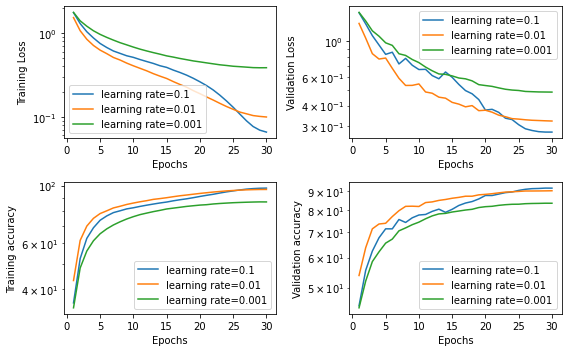

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.subplot(2,2,1)
for lr, train_loss in zip(rates, train_hists):
  plt.semilogy(np.arange(1,N_EPOCHS+1), train_loss, label='learning rate={}'.format(lr));
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.tight_layout()

plt.subplot(2,2,2)
for lr, valid_loss in zip(rates, valid_hists):
  plt.semilogy(np.arange(1,N_EPOCHS+1), valid_loss, label='learning rate={}'.format(lr));
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.tight_layout()

plt.subplot(2,2,3)
for lr, train_acc in zip(rates, train_acc_hists):
  plt.semilogy(np.arange(1,N_EPOCHS+1), train_acc, label='learning rate={}'.format(lr));
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Training accuracy')
plt.legend()
plt.tight_layout()

plt.subplot(2,2,4)
for lr, valid_acc in zip(rates, valid_acc_hists):
  plt.semilogy(np.arange(1,N_EPOCHS+1), valid_acc, label='learning rate={}'.format(lr));
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()
plt.tight_layout()